In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")

custom_palette = ["black", "red", "green", "orange", "blue"]
sns.set_palette(custom_palette)

model_type = 'EqOdd_thr'
calib_method = 'logx_logreg'
save_plots=True

args = {'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval/plots', 'paper_plots'),
        'eval_fold':  'eval',
        'grp_label_dict': {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'} 
       }

In [6]:
plot_df_all = []

for experiment in ['original_pce', 'apr14_erm', 'apr14_erm_recalib', 'apr14_mmd', 'apr14_thr']:
    aggregate_path = os.path.join(args['base_path'], 'experiments', 
                                  experiment, 'performance',
                                  'all')
    
    
    preds_path = os.path.join(aggregate_path, 'predictions.csv')

    preds = pd.read_csv(preds_path)
    if 'model_id' not in preds.columns:
        preds = preds.assign(model_id=0)
    if 'fold_id' not in preds.columns:
        preds = preds.assign(fold_id=0)

    #discovery_omission = get_false_discovery_omission(preds)
    df_general = pd.read_csv(os.path.join(aggregate_path, 'standard_evaluation.csv'))
    df_fair = pd.read_csv(os.path.join(aggregate_path, 'fairness_evaluation.csv'))
    
    thr_calibs = pd.read_csv(os.path.join(aggregate_path, 'calibration', calib_method, 'calibration_sensitivity_thresholds_raw.csv'))
    
    thr_calibs = (thr_calibs
                  .assign(metric = lambda x: 'outcome_rate_' + x.pred_probs.map({0.075: '075', 0.2: '20'}))
                  .rename(columns = {'calibration_density': 'performance'})
                  .filter(df_fair.columns)
                 )

    plot_df = (df_general
               .append(df_fair)
               .append(thr_calibs)
              )
    
    if 'model_id' not in plot_df.columns:
        plot_df = plot_df.assign(model_id=0)
    if 'fold_id' not in plot_df.columns:
        plot_df = plot_df.assign(fold_id=0)
        

    plot_df = (plot_df
                    .set_index(['model_id','fold_id'], drop=True)
                    .filter(['metric', 'performance_overall', 'performance', 'violation', 'group'])
                    .drop_duplicates()
                    .reset_index()
               #.append(discovery_omission)
               .assign(model_type = experiment)
    )  
    
    plot_df_all.append(plot_df)  
    
plot_df_all = pd.concat(plot_df_all)
plot_df_all = plot_df_all.assign(
    model_type = lambda x: x.model_type.map(
        {'original_pce': 'PCE',
         'apr14_erm': 'ERM',
         'apr14_erm_recalib': 'rERM',
         'apr14_mmd': 'EqOdd_mmd',
         'apr14_thr': 'EqOdd_thr'}
    )
)

plot_df_all = (plot_df_all
 .drop(columns=['performance'])
 .assign(group='all')
 .drop_duplicates()
 .rename(columns={'performance_overall': 'performance'})
 .append(plot_df_all)
 .drop(columns=['performance_overall'])
)

In [3]:
# to_plot1 = (plot_df_all
#            .query("(metric=='auc') | (metric=='auprc') | (metric=='loss_bce')")
#            .assign(metric = lambda x: x.metric.map({'auc': 'AUC', 'auprc': 'AUPRC', 'loss_bce': 'loss'}),
#                   row='A')
#           )
# to_plot2 = (plot_df_all
#            .query("(metric=='emd_0_ova') | (metric=='emd_1_ova') | (metric=='ace_rmse_logistic_log')")
#            .assign(metric = lambda x: x.metric.map({'emd_0_ova': 'EMD (no outcome)',
#                              'emd_1_ova': 'EMD (outcome)', 'ace_rmse_logistic_log': 'ACE'}),
#                   row='B')
#           )

# to_plot = to_plot1.append(to_plot2)

In [7]:
a=(plot_df_all
   .query("(metric==['emd_0_ova', 'emd_1_ova'])")
   .groupby(['model_id', 'fold_id', 'model_type']).mean()
   .reset_index()
   .assign(metric = 'eqodds_viol')
   #.rename(columns = {'performance': 'eqodds_viol'})
)
a.head()

b=(plot_df_all
   .query("metric=='ace_rmse_logistic_log'")
   .groupby(['model_id', 'fold_id', 'model_type']).mean()
   .reset_index()
   .assign(metric = 'ace_rmse_viol')
   #.rename(columns = {'performance': 'ace_rmse_viol'})
)
#a.groupby(['model_id', 'fold_id', 'model_type']).mean()
# (a.query("(metric=='emd_0_ova') | (metric=='emd_1_ova') ")
#   .performance
#                                .mean()
# )
tradeoffs = a.append(b)

In [8]:
tradeoffs_toplot = (tradeoffs
                    .pivot(index=['model_id', 'fold_id', 'model_type'], columns='metric', values='performance')
                    .reset_index()
                   )
tradeoffs_toplot.head()

metric,model_id,fold_id,model_type,ace_rmse_viol,eqodds_viol
0,0.0,0,PCE,0.039724,0.029281
1,0.0,0,rERM,0.020443,0.038040
2,0.0,1,ERM,0.019309,0.022151
3,0.0,2,ERM,0.019857,0.019776
4,0.0,3,ERM,0.022034,0.019469


In [26]:
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    costs = np.array(costs)
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return costs[is_efficient]



In [14]:
tradeoffs_toplot

metric,model_id,fold_id,model_type,ace_rmse_viol,eqodds_viol
0,0.0,0,PCE,0.039724,0.029281
1,0.0,0,rERM,0.020443,0.038040
2,0.0,1,ERM,0.019309,0.022151
3,0.0,2,ERM,0.019857,0.019776
4,0.0,3,ERM,0.022034,0.019469
...,...,...,...,...,...
207,1.0,8,EqOdd_thr,0.061471,0.003471
208,1.0,9,EqOdd_mmd,0.031934,0.012543
209,1.0,9,EqOdd_thr,0.065932,0.003486
210,1.0,10,EqOdd_mmd,0.031004,0.012489


In [16]:
tradeoffs_toplot.query()

metric,model_id,fold_id,model_type,ace_rmse_viol,eqodds_viol
0,0.0,0,PCE,0.039724,0.029281
1,0.0,0,rERM,0.020443,0.038040
2,0.0,1,ERM,0.019309,0.022151
3,0.0,2,ERM,0.019857,0.019776
4,0.0,3,ERM,0.022034,0.019469
...,...,...,...,...,...
207,1.0,8,EqOdd_thr,0.061471,0.003471
208,1.0,9,EqOdd_mmd,0.031934,0.012543
209,1.0,9,EqOdd_thr,0.065932,0.003486
210,1.0,10,EqOdd_mmd,0.031004,0.012489


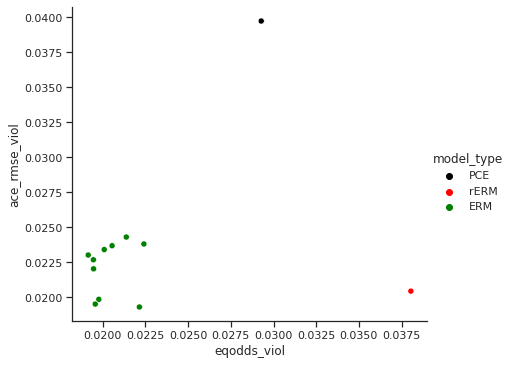

In [18]:
g = sns.relplot(data = tradeoffs_toplot.query("model_type!=['EqOdd_mmd', 'EqOdd_thr']"),
                x = 'eqodds_viol',
                y = 'ace_rmse_viol',
                kind = 'scatter',
                #col='model_type',
                hue = 'model_type',
                legend = True,
                #ci='sd',
                marker="o",
                aspect = 1.2,
               )

In [22]:
a = tradeoffs_toplot.query("model_type=='ERM'")
b = a.filter(['ace_rmse_viol', 'eqodds_viol'])
   
is_efficient = is_pareto_efficient_simple(a)
frontier_ERM = a[is_efficient]

In [25]:
frontier_ERM

metric,model_id,fold_id,model_type,ace_rmse_viol,eqodds_viol
2,0.0,1,ERM,0.019309,0.022151
3,0.0,2,ERM,0.019857,0.019776
4,0.0,3,ERM,0.022034,0.019469
6,0.0,5,ERM,0.019518,0.019566
7,0.0,6,ERM,0.022679,0.019459
8,0.0,7,ERM,0.023020,0.019154


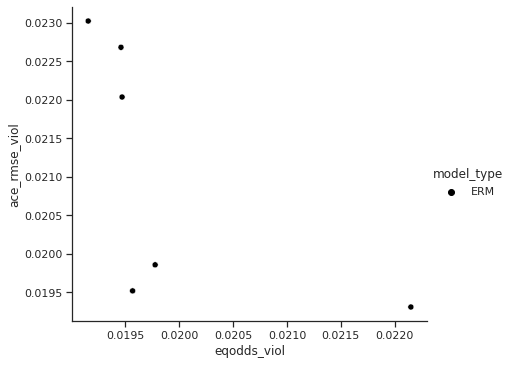

In [24]:
g = sns.relplot(data = frontier_ERM,#tradeoffs_toplot.query("model_type=='EqOdd_mmd'"),
                x = 'eqodds_viol',
                y = 'ace_rmse_viol',
                kind = 'scatter',
                #col='model_type',
                hue = 'model_type',
                legend = True,
                #ci='sd',
                marker="o",
                aspect = 1.2,
               )

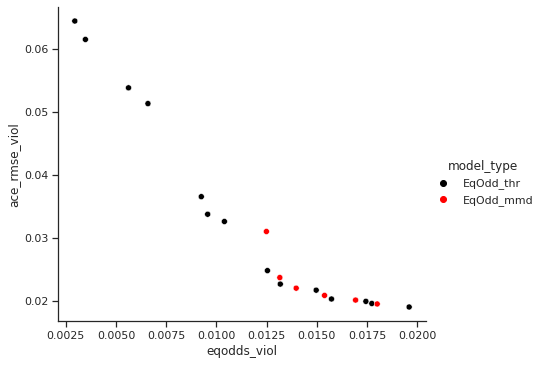

In [13]:
a= (tradeoffs_toplot
    .query("model_type=='EqOdd_mmd'")
    .filter(['ace_rmse_viol', 'eqodds_viol'])
   )
is_efficient = is_pareto_efficient_simple(np.array(a))
frontier_test = tradeoffs_toplot[is_efficient]
#frontier_test = frontier_test.sort_values(by ='eqodds_viol').reset_index(drop=True)




g = sns.relplot(data = frontier_test,#tradeoffs_toplot.query("model_type=='EqOdd_mmd'"),
                x = 'eqodds_viol',
                y = 'ace_rmse_viol',
                kind = 'scatter',
                #col='model_type',
                hue = 'model_type',
                legend = True,
                #ci='sd',
                marker="o",
                aspect = 1.2,
               )

# g.axes[0,0].plot(frontier_test.eqodds_viol,
#                  frontier_test.ace_rmse_viol,
#                   #marker="o"
#                 )
#index_test = np.argsort(a[is_efficient][:,0])
# frontier_test = a[is_efficient][index_test]